<font size = 6> Прогнозирование вероятности оттока клиентов </font>

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.  

**Задача:** провести анализ и подготовить план действий по удержанию клиентов. А именно:
- cпрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
* 'Churn' — факт оттока в текущем месяце.

## Получение данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt

In [2]:
# читаем данные и выводим info и первые 5 строк
try:
    df = pd.read_csv('gym_churn.csv')
except Exception as e:
    print(f'{e} Локальная версия файла не найдена. Загрузка с ЯП')
    df = pd.read_csv('*****') # удалено, запрет иьсточника

print('Размер датасета', df.shape)
print('')
df.info()
display(df.head())

Размер датасета (4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total   

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Вывод** Данные представляют собой датасет размером 4000 х 14. Пропуски отсутствуют. Типы данных соответствуют их смыслу.

## Исследовательский анализ данных

In [3]:
# Оценим число и долю ушедших клиентов
print('Число ушедших клиентов: ', df['Churn'].sum())
print('Доля ушедших клиентов : ', df['Churn'].sum()/df['Churn'].count())

Число ушедших клиентов:  1061
Доля ушедших клиентов :  0.26525


Из 4000 клиентов, чуть больше четверти ушли.

### Основные статистические показатели

In [4]:
# зададим формат отображения, два знака после запятой
pd.options.display.float_format = '{:.2f}'.format

# воспользуемся discribe для отображения основных стат.показателей
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


- gender: по полу распределение почти ровномерное (1 чуть больше);
- Near_Location: более 25% клиентов проживают или работают в районе, где находится фитнес-центр;
- Partner: чуть менее 50% от общего числа клиентов это сотрудники компании-партнёра клуба;
- Promo_friends: около 30% клиентов участники акции «приведи друга»;
- Phone: для более чем 90% клиентов указан контактный телефон;
- Contract_period: более половины клиентов имеет месячные контракты, годовые абонементы у менее чем 25% клиентов;
- Group_visits: чуть более 40% клиентов посещают групповые занятия;
- Age: минимальный возраст 18, максимальный 41, медиана и среднее около 29;
- Avg_additional_charges_total: у всех клиентов платные доп.услуги. Равномерное распределение по квартилям, 25% - 70, 50% - 140 (2х70), 75% - 210(3х70);
- Month_to_end_contract: распределение схоже с Contract_period;
- Lifetime: медиана 3, среднее 3.72 говорят о том что есть некоторое количество "преданных" клиентов ("выбросы")
- Avg_class_frequency_total и Avg_class_frequency_current_month: распределения похожи. Незначительное увеличение по current_month может бфть обусловлено новыми клиетами, которые уходят в том же месяце.
- Churn: 27% клиентов ушло.

In [5]:
# посмотрим на среднии показатели по группам оставшихся и ушедших
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Сходные значения только по gender и Phone.  
Для ушедших, в среднем, характерно:
- более дальнее проживание/работа относительно фитнеса;
- меньшая доля в акции "приведи друга" (18% vs 35%);
- короткий срок договора (1.7 vs 5.7);
- меньшее посещение групповых занятий (30% vs 50%);
- меньший возраст (27 vs 30);
- меньшие расходы на доп.услуги (115 vs 158);
- меньший срок до истечения действия договора (1.7 vs 5.3);
- срок пользования (1 vs 4.7) т.е. в среднем после месяца пользования договор не продлевают.

###  Гистограммы и распределения признаков

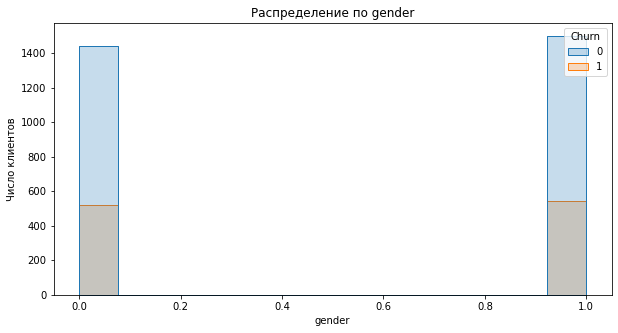

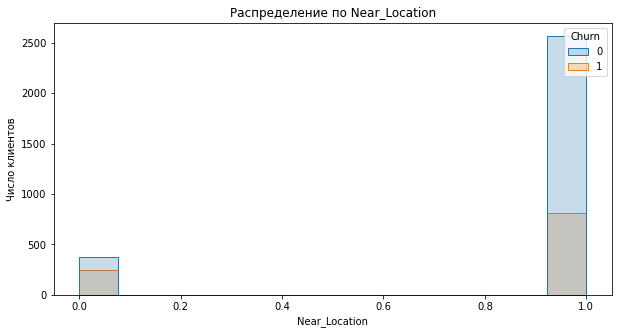

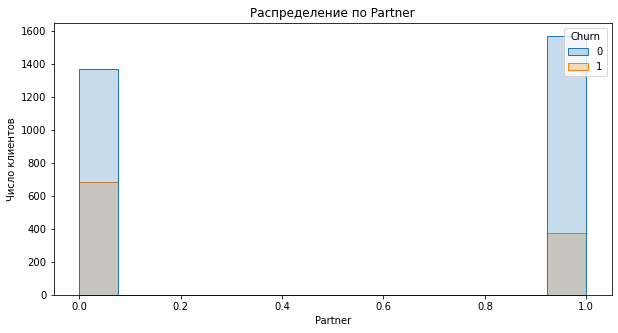

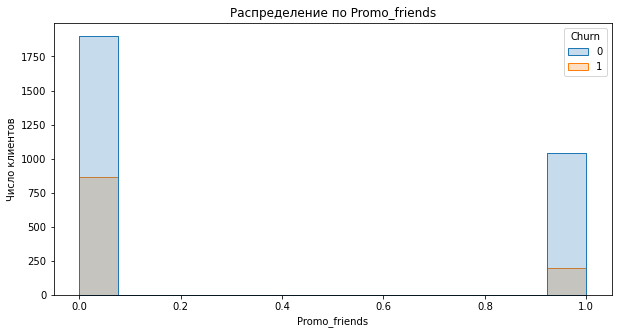

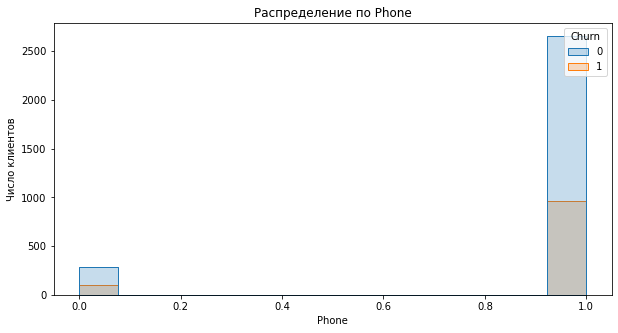

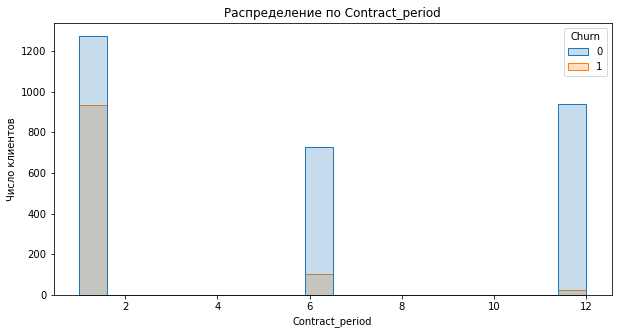

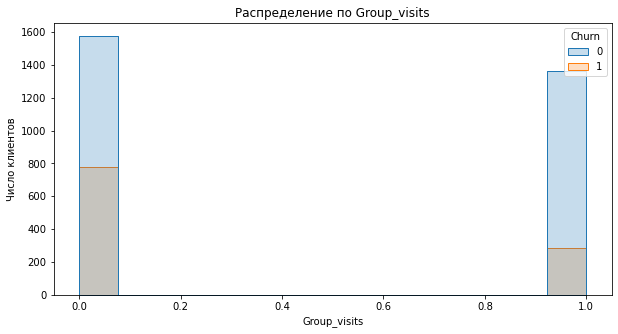

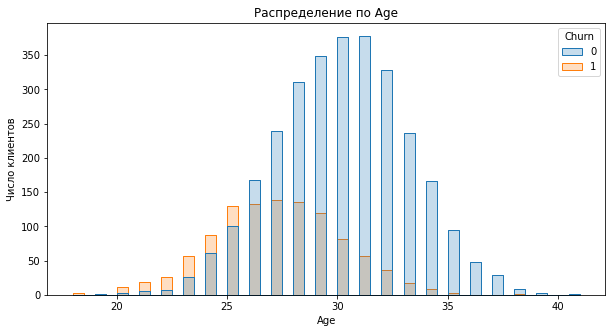

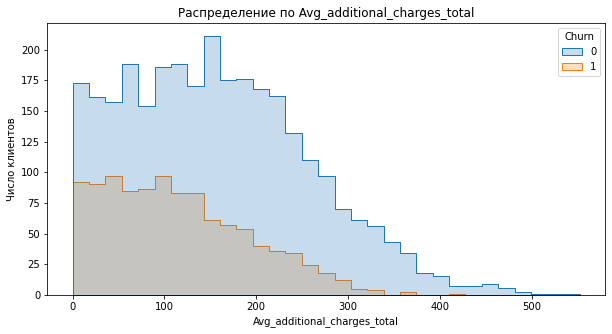

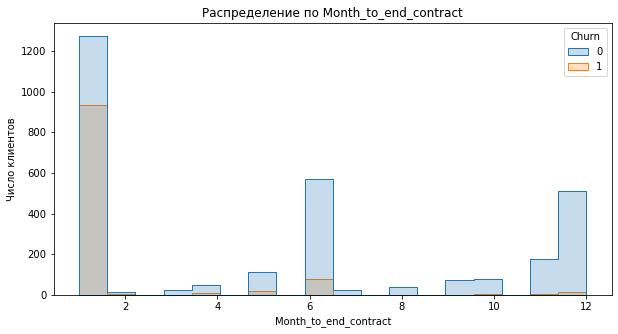

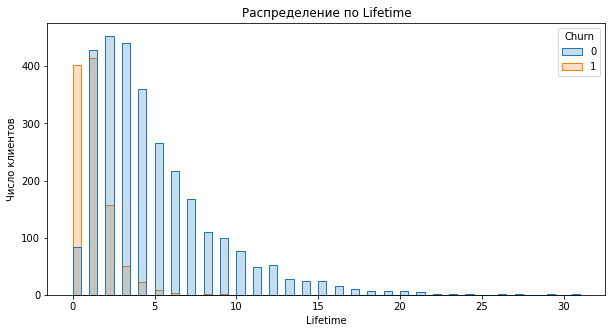

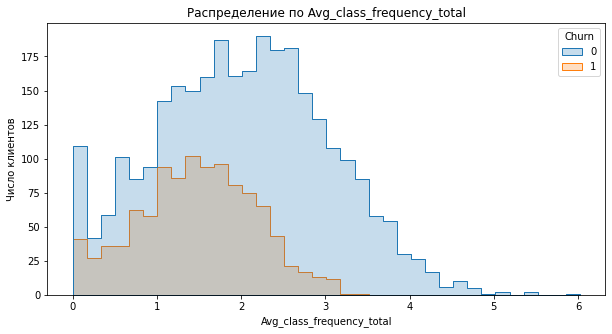

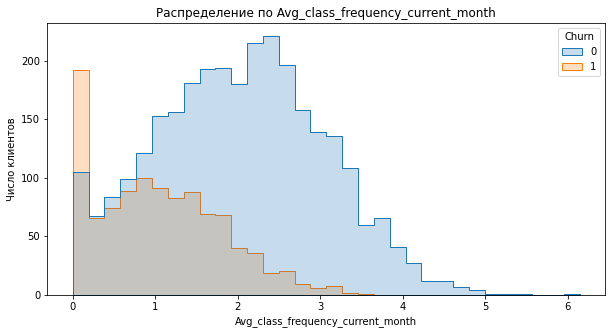

In [6]:
# построим диаграммы распределения для каждого из параметров с разделением по Churn
for item in df.columns[:-1]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Распределение по {item}')
    sns.histplot(x=item, data=df, hue="Churn", element="step")
    plt.ylabel("Число клиентов", fontsize=10)
    plt.show()

В добавление в выводам сделанным ранее, можно отметить, что распределения для непрерывных величин (Age, Avg_additional_charges_total,	Lifetime, Avg_class_frequency_total, Avg_class_frequency_current_month) схожи по форме но для ушедших имеют меньший масштаб и сдвинуты влево.

### Матрица корреляции

In [7]:
# матрица корреляции
df.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
Near_Location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
Partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
Promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
Phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
Contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
Group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
Age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
Avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
Month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


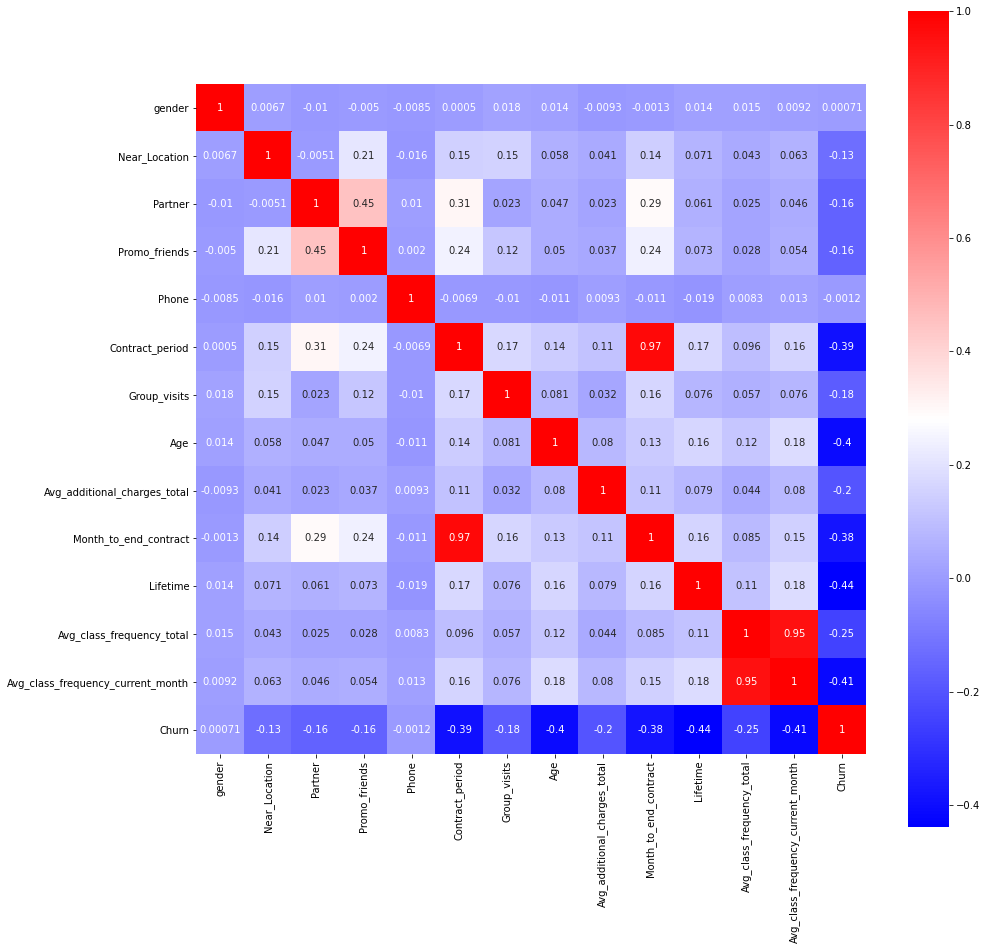

In [8]:
# визуализируем матрицу корреляции
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), square = True, annot = True, cmap='bwr')
plt.show()

Таблица корреляции показывает: 
1. наибольшую обратную зависимость факта ухода от:
    - времени с момента првого обращения в фитнес, 
    - среднего числа посещений в текущем месяце,
    - возраста,
    - срока действия договора,
    - срока до окончания действия договора
2. единстверрная прямая зависимость - пол, но коэффициент корреляции на столько мал, что можно говорить об отсутствии связи
3. наличие сильно скоррелированных признаков: Contract_period и Month_to_end_contract, Avg_class_frequency_total и Avg_class_frequency_current_month. При наличии таких связей (мультиколлинеарности), могут возникнуть проблемы при построении модели линейной регрессии. Что бы этого избежать, необходимо удалить по одному признаку из каждой пары 
4. признак Phone имеет крайне слабую корреляционную связь со всеми другими признакими

In [9]:
dfs =  df.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month'] , axis = 1)
dfs.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
0,1,1,1,1,0,6,1,29,14.23,3,0.02,0
1,0,1,0,0,1,12,1,31,113.20,7,1.92,0
2,0,1,1,0,1,1,0,28,129.45,2,1.86,0
3,0,1,1,1,1,12,1,33,62.67,2,3.21,0
4,1,1,1,1,1,1,0,26,198.36,3,1.11,0


## Модель прогнозирования оттока клиентов

### Алгоритм логистической регрессии

Поставленная задача - это задача бинарной классификации.  
Для решения задачи воспользуемся алгоритмом логистическая регрессия.  
Алгоритм реализован как класс LogisticRegression() в модуле linear_model библиотеки sklearn.

In [10]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = dfs.drop('Churn', axis = 1)
y = dfs['Churn']

In [11]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [13]:
# зададим алгоритм для нашей модели - логистическая регрессия
lr_model = LogisticRegression(random_state = 0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# делаем прогноз на тестовой выборке
lr_predictions = lr_model.predict(X_test_st) 

# выведем метрики для полученного прогноза
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.4f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.4f}'.format(recall_score(y_test, lr_predictions)))

Accuracy: 0.8988
Precision: 0.7882
Recall: 0.8081


### Алгоритм случайный лес

Сравним полученный результат с результатом полученным с использованием алгоритма случайный лес.  
Алгоритм реализован как класс RandomForestClassifier() в модуле ensemble библиотеки sklearn.

In [14]:
# зададим алгоритм для нашей модели - случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель
rf_model.fit(X_train_st, y_train)

# делаем прогноз на тестовой выборке
rf_predictions = rf_model.predict(X_test_st) 

# выведем метрики для полученного прогноза
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.4f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.4f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.8900
Precision: 0.7865
Recall: 0.7626


### Сравнение моделей

- accuracy. Метрика показывает долю верно угаданных ответов из всех прогнозов. Такая доля для регресси немного выше.
- precision. Метрика показывает, какая доля прогнозов относительно "1" класса верна. По этой метрике регрессия лучше леса.
- recall. Метрика показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. И тут логистическая регрессия показала лучший результат.   

**Вывод** Модель прогнозирования оттока клиентов построенная на алгоритме логистической регрессии показала лучший результат на тестовой выборке.

## Кластеризация клиентов

In [15]:
# обучаем нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(df.drop('Churn', axis = 1)) 

# построим матрицу расстояний
linked = linkage(x_sc, method = 'ward')

### Дендрограмма

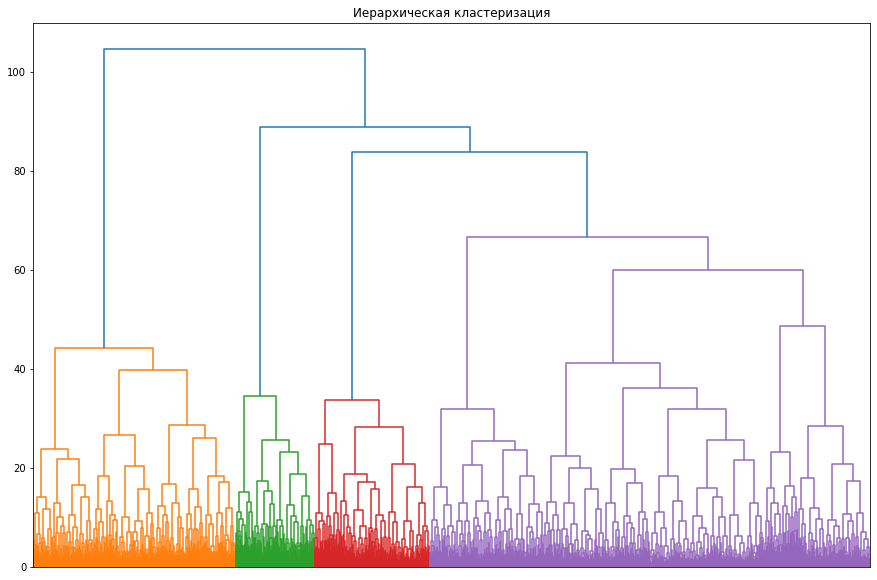

In [16]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.xticks(ticks=[])
plt.show()

Дендрограмма предлагает оптимальное число кластеров 4.

### Модель кластеризации

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. По условию задания число кластеров принимаем n=5.



In [17]:
# задаём число кластеров равное 5 (по условию)
km = KMeans(n_clusters=5, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc) 

In [18]:
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
cluster_features = df.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Выведем отдельно значения абсолютного и относительного оттоков по кластерам.

In [19]:
dft =( 
    df.groupby('cluster')
    .agg({'gender': 'count', 'Churn':'sum'})
    .reset_index()
    .rename(columns={'gender': 'total'}))
dft['Churn_ratio'] = round(dft['Churn'] / dft['total'], 4)
numeric_columns = dft.drop(columns=['cluster']).columns
display(dft.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns))


,cluster,total,Churn,Churn_ratio
0,0,1010.00,28.00,0.03
1,1,385.00,103.00,0.27
2,2,505.00,224.00,0.44
3,3,1262.00,649.00,0.51
4,4,838.00,57.00,0.07


Видим, что 0-ой и 4-ый кластеры наименее склонны к оттоку. Более половины клиентов 3-го кластера уходят в отток. Кроме того, 2-ой кластер тоже имеет достаточно высокий процент оттока.

Для сравнения, посмотрим эти показатели на том же алгоритме, но задав число кластеров рекоментоданное дендрограммой - 4

In [20]:
# задаём число кластеров равное 4
km4 = KMeans(n_clusters=4, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров 
labels4 = km4.fit_predict(x_sc) 
df4 = df.drop('cluster', axis = 1)
# сохраняем метки кластера в поле нашего датасета
df4['cluster'] = labels4
# выводим статистику по средним значениям наших признаков по кластеру
cluster_features = df4.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
display(cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns))

dft4 =( 
    df4.groupby('cluster')
    .agg({'gender': 'count', 'Churn':'sum'})
    .reset_index()
    .rename(columns={'gender': 'total'}))
dft4['Churn_ratio'] = round(dft4['Churn'] / dft4['total'], 4)
numeric_columns = dft4.drop(columns=['cluster']).columns
display(dft4.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns))

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,1,0.49,0.76,0.38,0.19,1.00,1.90,0.29,28.05,129.70,1.81,2.24,1.20,0.95,0.56
2,2,0.54,0.86,0.34,0.21,1.00,2.40,0.45,29.99,157.36,2.24,4.70,2.72,2.71,0.09
3,3,0.50,0.94,0.78,0.57,1.00,10.70,0.54,29.91,161.36,9.77,4.73,1.98,1.98,0.03


,cluster,total,Churn,Churn_ratio
0,0,386.00,103.00,0.27
1,1,1479.00,828.00,0.56
2,2,1057.00,98.00,0.09
3,3,1078.00,32.00,0.03


В модели с четырьмя кластерами группа склонная к оттоку выражена более явно - 1-ый кластер. Этот кластер самый многочисленный по числу клиентов - 35% от общего числа. Более 50% клиентов принядлежат к кластерам 2 и 3 с наименьшей долей оттока. Кластер 3 имеет савые длинные контракты. 

Характерные черты клиентов кластера 1, в среднем:
- дальше живут/работают
- меньший срок контракта (месяц)
- меньше посещают групповые занятия
- моложе
- меньше траты на доп.услуги
- более "новые клиенты"

** - Характеристики 1-го кластера в общем и целом соответствуют выводам сделаннам на этапе EDA для группы оттока

Для обеих моделей в разным, с числом кластеров 4 и 5, характерно выделение группы клиентов без контактного номера в отдельный кластер.

### Распределение признаков по кластерам

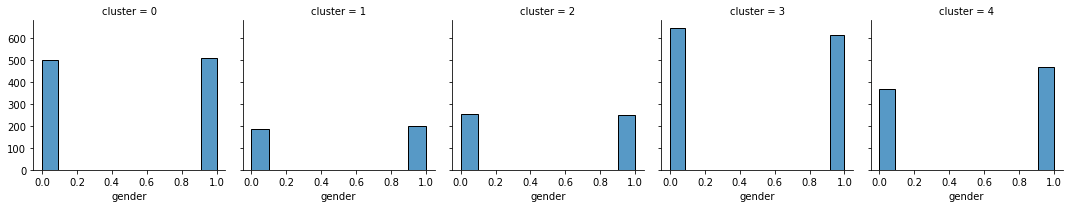

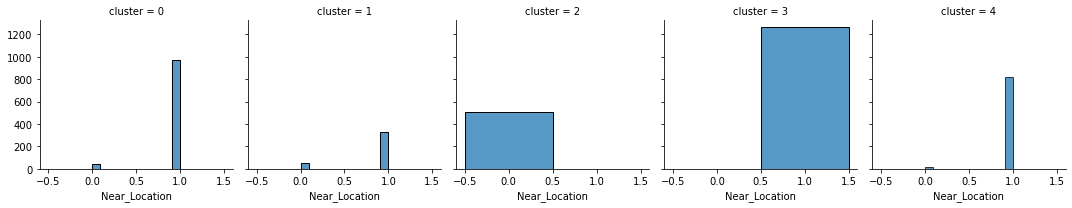

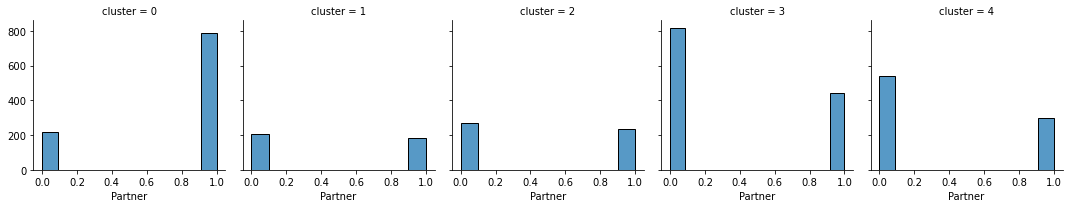

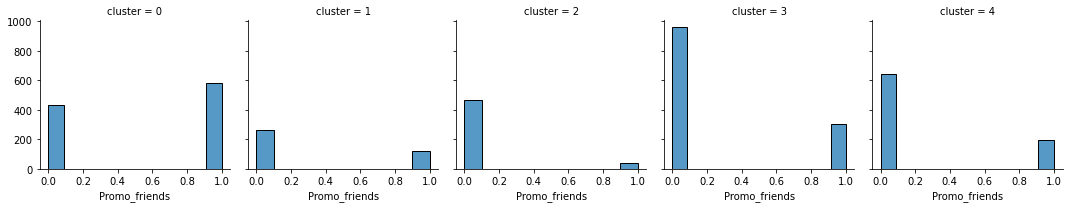

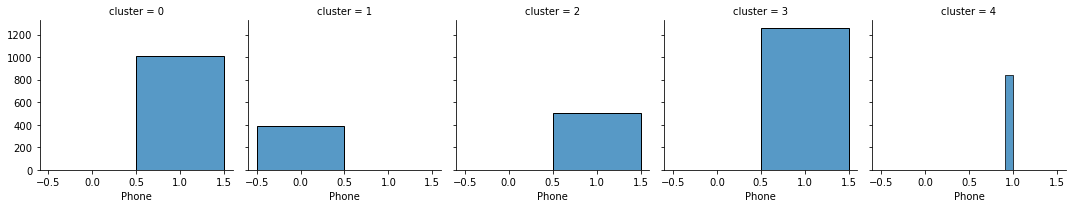

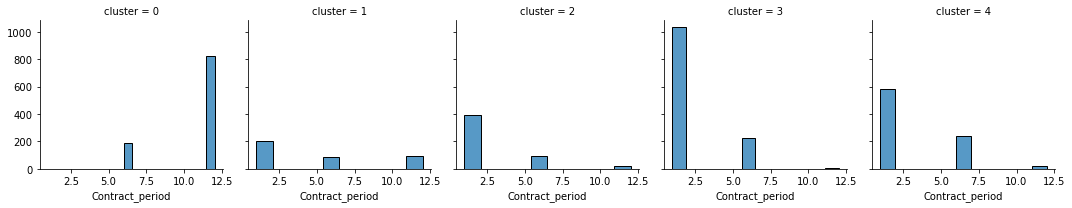

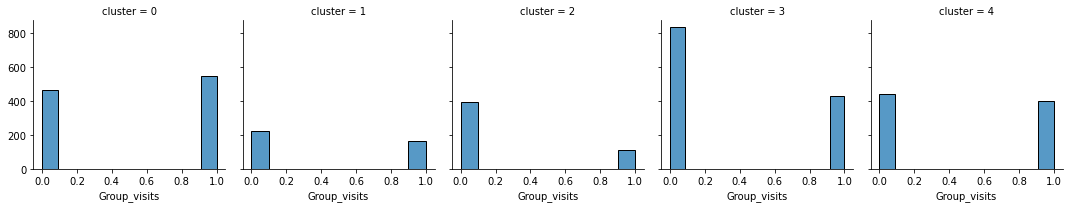

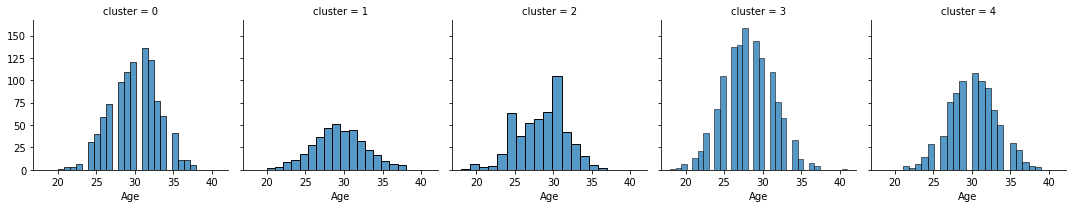

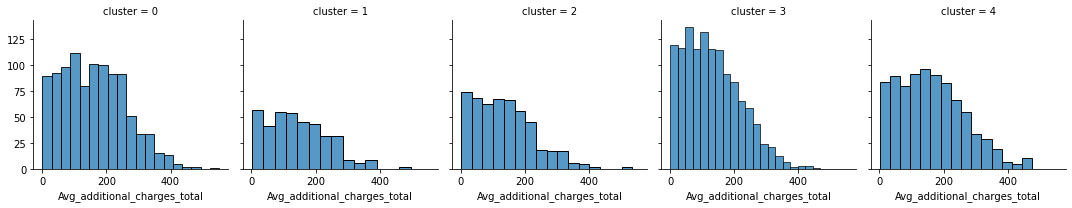

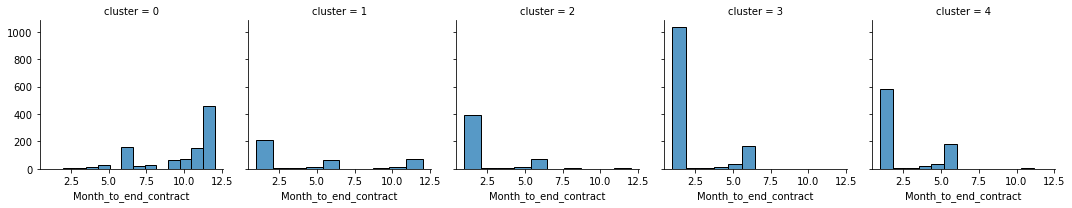

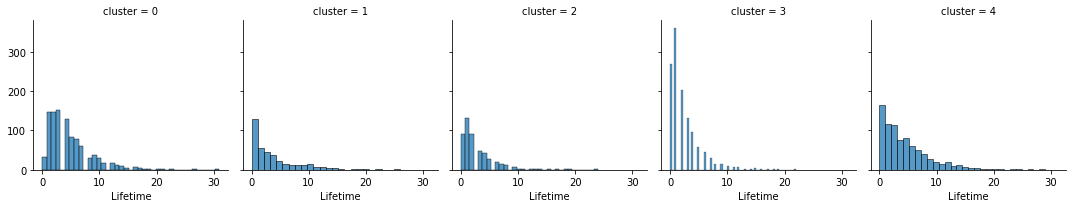

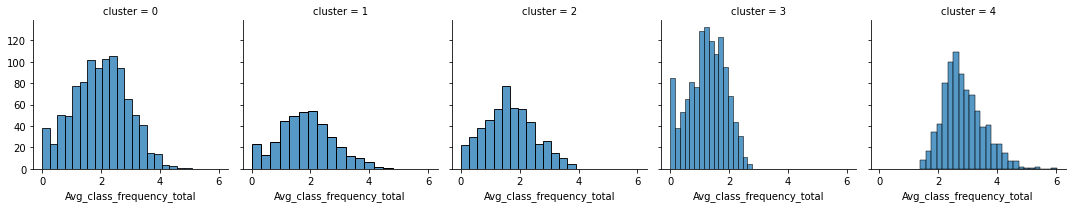

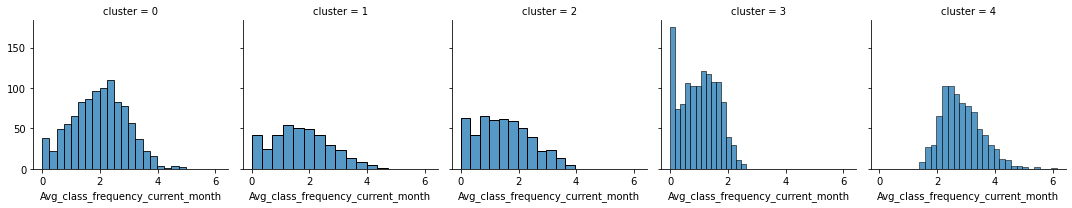

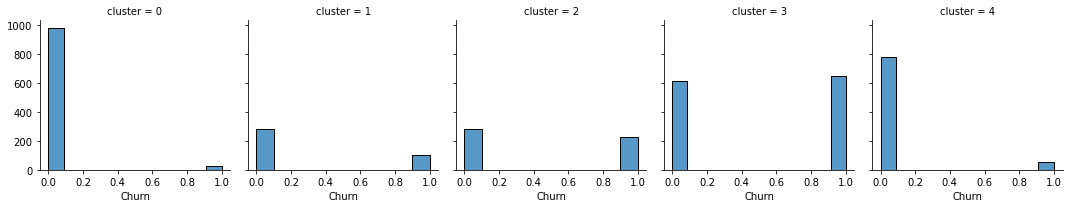

In [21]:
# построим гистограммы распределения признаков по 5 кластерам
for item in df.columns[:-1]:
    g = sns.FacetGrid(df, col="cluster")
    g.map(sns.histplot, item)
    plt.show()

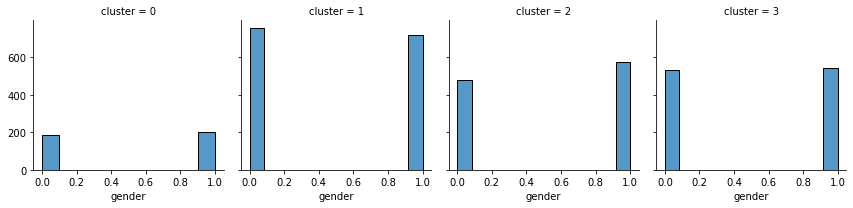

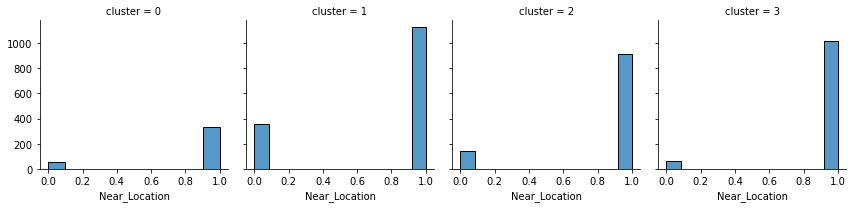

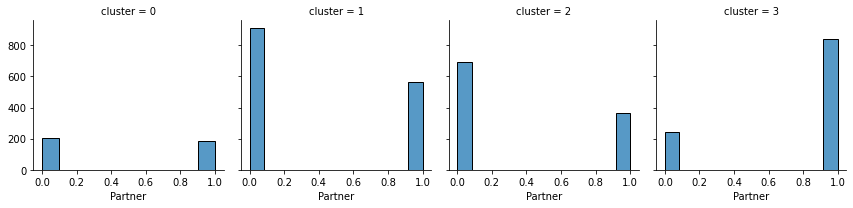

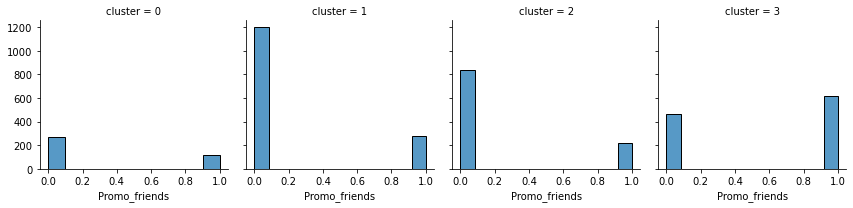

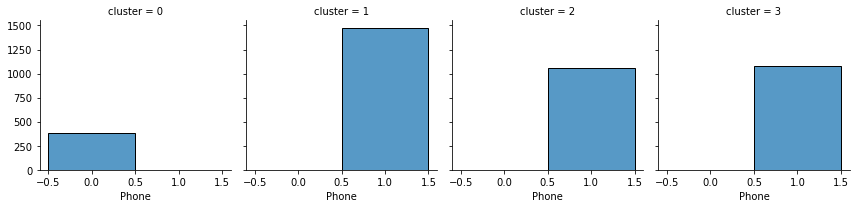

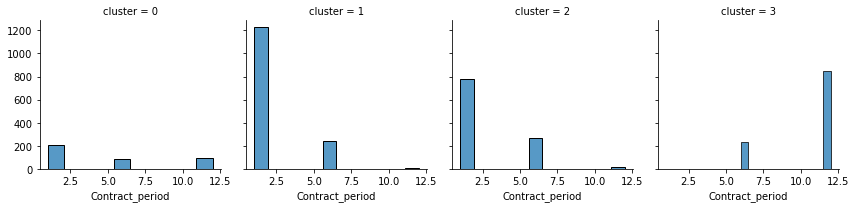

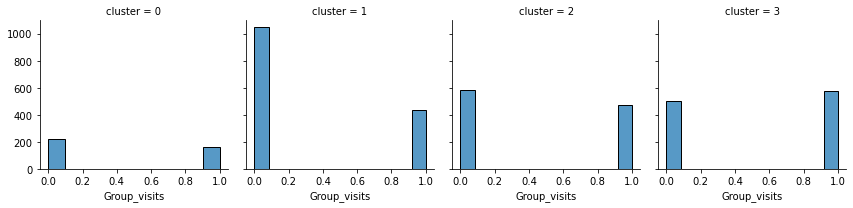

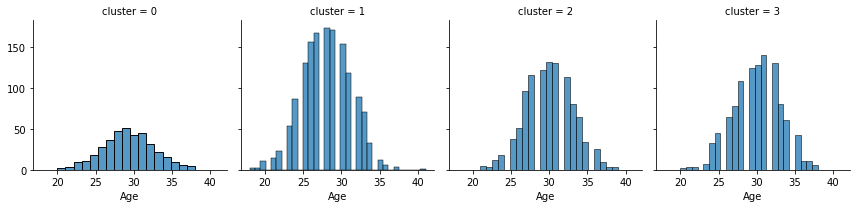

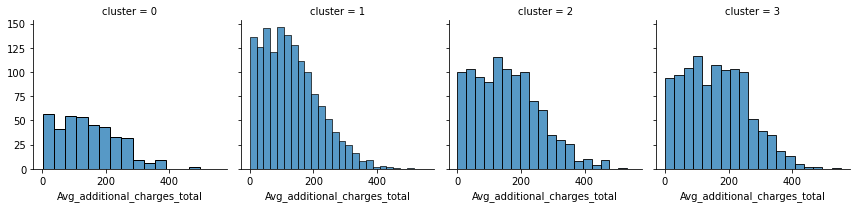

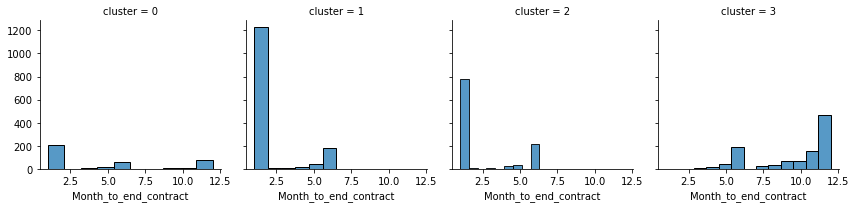

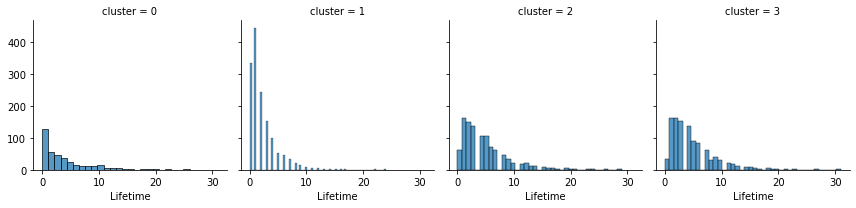

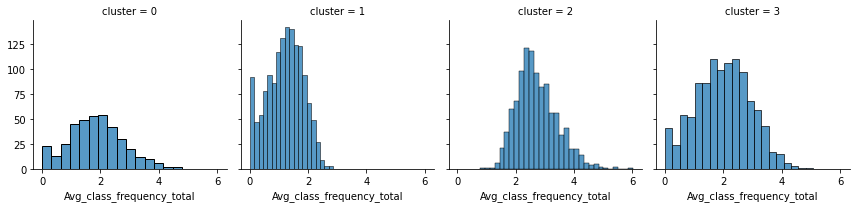

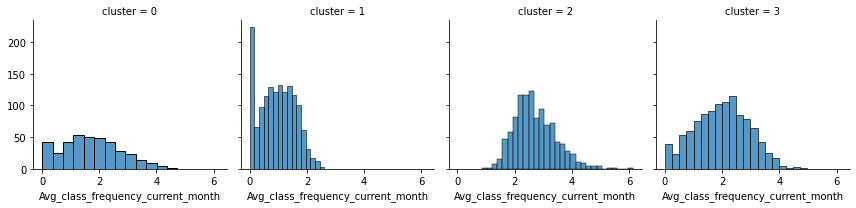

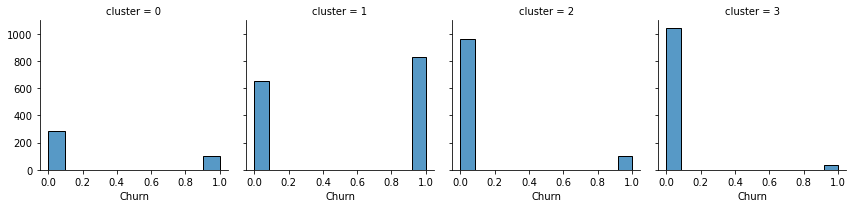

In [22]:
# построим гистограммы распределения признаков по 4 кластерам
for item in df4.columns[:-1]:
    g = sns.FacetGrid(df4, col="cluster")
    g.map(sns.histplot, item)
    plt.show()

Все сделанные ранее предроложения подтверждаются. Отток, в основном, идёт по новым клиентам заключивщим короткие договрора,  попробовали - не понравилось. Большое число таких клиентов не посещает групповые занятия.

Можно выделить границы:
- по признакам Near_Location и Ave_class_frequency для кластеров 0,1 и 2,3;
- по признакам Partner и Avg_class_frequency для кластеров 0,1 и 2,3;
- по признакам Age и Phone для кластеров 0 и 1,2,3;
- по признакам Avg_additional_charges и Phone для кластеров 0 и 1,2,3;
- по признакам Month_to_end_contract и Phone для кластеров 0 и 1,2,3;
- по признакам Lifetime и Phone для кластеров 0 и 1,2,3;
- по признакам Avg_class_frequency и Phone для кластеров 0 и 1,2,3;
- по признакам Age и Contract_period для кластеров 3 и 0,1,2;
- по признакам Avg_additional_charges и Contract_period для кластеров 1 и 0,2,3;
- по признакам Lifetime и Contract_period для кластеров 3 и 0,1,2;
- по признакам Avg_class_frequency и Contract_period для четырёх кластеров;
- по признакам Month_to_end_contract и Age для кластеров 3 и 0,1,2;
- по признакам Avg_class_frequency и Age для кластеров 0,1 и 2,3;
- по признакам Avg_class_frequency и Avg_additional_charges для кластеров 1 и 2;
- по признакам Lifetime и Month_to_end_contract для кластеров 1 и 3;
- по признакам Avg_class_frequency и Month_to_end_contract для кластеров 1,2,3;
- по признакам Avg_class_frequency и Lifetime для кластеров 1 и 2;
- по признакам Avg_class_frequency_current_month и Avg_class_frequency_total для кластеров 1 и 2

### Описание кластеров

**Кластер 0**  
Не указали контактный телефон. В среднем, более 4-х месяцев до завершения договора.

**Кластер 1**  
Короткие контракты. Дальше всех живут. Среднее число посещений окого 1 раза в неделю.

**Кластер 2**  
Низкая доля сотрудников компаний партнёров. В среднем, более 2-х посещений в неделю.

**Кластер 3**  
Длинные контракты. Ближе всех живут. Около 2-х посещений в неделю. Больше всех тратят на доп.услуги. Больще половины по "приведи друга". Высокая доля сотрудников компаний партнёров.

## Выводы и рекомендации

На основании изучения данных о 4000 клиентов по 14 параметнам (13 признаков и целевая переменная), можно сделать следующие выводы:

   **Общая характеристика выборки:**
   - число клиентов ушедших в отток 1061 (26.5% от общего числа);
   - ровномерное распределение по полу;
   - более 25% клиентов проживают или работают в районе расположения фитнес-центр;
   - 50% клиентов - это сотрудники компании-партнёра клуба;
   - 30% клиентов участники акции «приведи друга»;
   - 90% клиентов указывают контактный телефон;
   - более половины клиентов имеют месячные контракты, годовые абонементы у менее чем 25% клиентов;
   - 40% клиентов посещают групповые занятия;
   - минимальный возраст 18, максимальный 41, медиана и среднее около 29;
   - у всех клиентов платные доп.услуги. Равномерное распределение по квартилям, 25% - 70, 50% - 140 (2х70), 75% - 210(3х70);
   - у более чем половины клиентов месяц до окончания действия договора;
   - медиана 3, среднее 3.72 говорят о том что есть некоторое количество "преданных" клиентов ("выбросы")
   - средняя продолжительность посещения центра по предстадленным банным  - более 3 месяцев
   - менее 25% клинтов посещают финдес до 1 раза в неделю, 50% от 1 до 2 раз, 25% - более 2 раз


   **Характерные черты группы оттока:**
   - более дальнее проживание/работа относительно фитнеса;
   - меньшая доля в акции "приведи друга";
   - короткий срок договора;
   - меньшее посещение групповых занятий;
   - меньший возраст;
   - меньшие расходы на доп.услуги;
   - меньший срок до истечения действия договора;
   - срок пользования месяц т.е. в среднем после месяца пользования договор не продлевают.
   
   
   **Рекомендации по удержанию клиентов:**
   1. На фактор локации у нас влияния нет. В группе из "дальней" локации более 40% уходят в оттток. Хотя, общее число таких клиентов до 20%, можно попробовать ввести промо скидку на оплату следующего периода, или предложить бесплатную доп.услугу в качестве компенсации.
   2. Оплата первичного договора про ходит по стандартной цене (без промо кода). При этом, как правило, это короткий месячный договор. Клиент может не успеть "втянуться". Возможно, стоимт предложить клиенту пролонгацию договора со скидкой.
   3. Избегать коротких договоров. Дать клиенту время "втянуться". Например, увеличить минимальный срок договора до 2-3 месяцев с сохранинием цены.
   4. Провести исследование причин отказа от посещения групповые занятия: неудобное время, формат, дисциплина, что-то еще.
   5. Обратить внимание, вести, быть в контакте с клиентами первого месяца. 